tgb - 1/8/2020 - Figures 1 and 2 for my birthday to prepare our MPI project for submission. Heavily based on Julia's notebooks:    
Figure 1 = [https://github.com/tbeucler/2019_WMI/blob/master/dev/jwindmiller/Bistability_Fig1.ipynb]  
Figure 1 long-time average for ERA = [https://github.com/tbeucler/2019_WMI/blob/master/dev/jwindmiller/Seasonal_cycle.ipynb]  
Figure 1 PDF for COSMO = [https://github.com/tbeucler/2019_WMI/blob/master/dev/tbeucler/014_Unified_Figures_1_and_2.ipynb]
Figure 2 = [https://github.com/tbeucler/2019_WMI/blob/master/dev/jwindmiller/Potential_LFE_Fig2.ipynb]

# 0) Initialization

## 0.1) Imports

In [1]:
# Initial imports
import util.Landau_Potential_Diffusion as Landau
import util.curvature as curve
import util.pdf as PDF

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import matplotlib.transforms as mtransforms
import datetime
from skimage import measure
from scipy import ndimage, stats
import scipy.integrate as sin
from scipy.optimize import curve_fit
from scipy.ndimage.filters import gaussian_filter1d
import random
import pandas as pd

import pickle

In [2]:
# Figure characteristics common to all Figures
fz = 15
lw = 3
siz = 10

plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
mpl.rcParams['lines.markersize'] = siz
plt.close('all')

# Physical constants
stday = 24*3600

In [3]:
col1 = np.array([255,126,14])/255
col2 = np.array([43,160,43])/255
col3 = np.array([31,119,179])/255

col_A = ['C0', 'C1', 'C2']

## 0.2) Utilities

In [4]:
class Bunch(object):
  
    def __init__(self, adict):
        self.__dict__.update(adict)

In [5]:
def edgTObin(edges):
    return 0.5*(edges[1:]+edges[:-1])

In [6]:
def get_all_values(dic_values):
    values = []
    for i_k, key in enumerate(dic_values.keys()):
        values.extend(dic_values[key])
    return values

In [7]:
def find_index(time_A, time_cond):
    ind = np.where(time_A == time_cond)[0][0]
    return ind

# 1) Figure 1

## 1.1) COSMO simulations (Fig 1a and 1c)

### 1.1.1) Figure 1a = Final (aggregated) state of column water vapor

#### Make Figure

In [8]:
path_RCE = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_506x506/output/'

In [9]:
RCE300 = xr.open_mfdataset(path_RCE+'lfff????????.nc')

/users/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/users/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
RCE300

(array([1.64502040e+07, 9.05286360e+07, 1.19597016e+08, 1.39182160e+08,
        1.00704484e+08, 5.28810220e+07, 3.47309430e+07, 2.82595750e+07,
        3.10327510e+07, 1.11960900e+06]),
 array([14.345098, 21.542734, 28.74037 , 35.938004, 43.135643, 50.33328 ,
        57.530914, 64.728546, 71.926186, 79.12382 , 86.32146 ],
       dtype=float32),
 <a list of 10 Patch objects>)

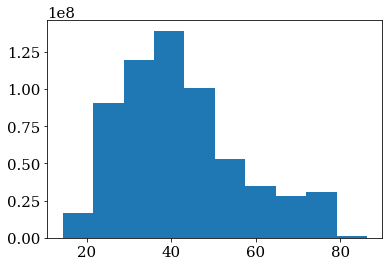

In [16]:
plt.hist(RCE300.TQV.values.flatten())

tgb - 1/20/2020 - Figure 1 is the CWV field

In [40]:
SPINstart = 0 #days
COALstart = 11 #days
COARstart = 25 #days
ENDstart = 85 # days

In [41]:
CWV_agg = RCE300.TQV[(24*ENDstart):].mean(dim='time')

In [42]:
CWV_agg

<xarray.DataArray 'TQV' (rlat: 506, rlon: 506)>
dask.array<shape=(506, 506), dtype=float32, chunksize=(506, 506)>
Coordinates:
  * rlon        (rlon) float32 0.0 0.03 0.06 ... 15.089999 15.12 15.15
  * rlat        (rlat) float32 0.0 0.03 0.06 ... 15.089999 15.12 15.15
    lon         (rlat, rlon) float32 -5.008956e-06 0.029994989 ... 15.149995
    lat         (rlat, rlon) float32 -2.504478e-06 -2.5044778e-06 ... 15.149999
    height_2m   float32 2.0
    height_toa  float32 33250.0

tgb - 1/20/2020 - Make the threshold the 88th percentile for consistency with Dave's section

In [43]:
CWV_p88 = np.percentile(CWV_agg,88)

In [44]:
CWV_p88

68.46531372070311

Evaluate values to plot and plot

In [190]:
toplot = CWV_agg.values

In [191]:
dx = 3.3
x = dx*CWV_agg.rlon
y = dx*CWV_agg.rlat

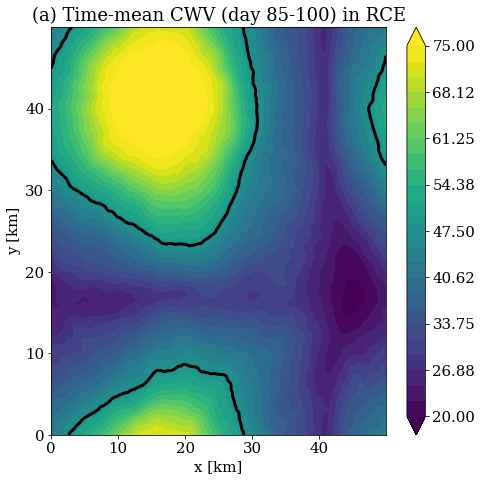

In [192]:
fig,ax = plt.subplots(figsize=(7.5,7.5))


ax.contour(x,y, toplot,[48.00],colors='k')
cont_levels = np.linspace(20,75,25)
im = ax.contourf(x, y, toplot, cont_levels, vmin = 20, vmax = 75, extend='both')
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_title('(a) Time-mean CWV (day 85-100) in RCE')
cbar = plt.colorbar(im)

#### Save reduced data

In [196]:
hf = open(pathPKL+'2020_01_08_COSMO_CWV.pkl','wb')

In [197]:
F1a_data={'x':x,'y':y,'toplot':toplot}

In [198]:
pickle.dump(F1a_data,hf)
hf.close()

#### Make Figure from reduced data

In [11]:
# Load reduced data into dictionary S
pathPKL = '/users/tbeucler/2019_WMI/dev/tbeucler/PKL_DATA/'
path = pathPKL+'2020_01_08_COSMO_CWV.pkl'
hf = open(path,'rb')
S = pickle.load(hf)
F1a = Bunch(S)

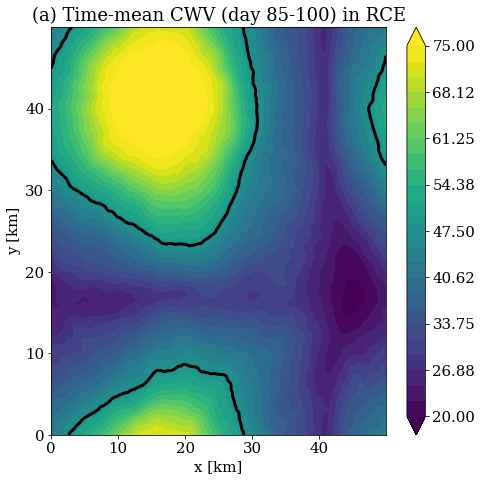

In [202]:
fig,ax = plt.subplots(figsize=(7.5,7.5))

ax.contour(F1a.x,F1a.y,F1a.toplot,[48.00],colors='k')
cont_levels = np.linspace(20,75,25)
im = ax.contourf(x, y, toplot, cont_levels, vmin = 20, vmax = 75, extend='both')
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_title('(a) Time-mean CWV (day 85-100) in RCE')
cbar = plt.colorbar(im)

### 1.1.2) Figure 1c = PDF of column water vapor

In [165]:
# Load reduced data into dictionary S
pathPKL = '/users/tbeucler/2019_WMI/dev/tbeucler/PKL_DATA/'
path = pathPKL+'2019_11_19_Fig1a.pkl'
hf = open(path,'rb')
S = pickle.load(hf)

In [166]:
F1c = Bunch(S)

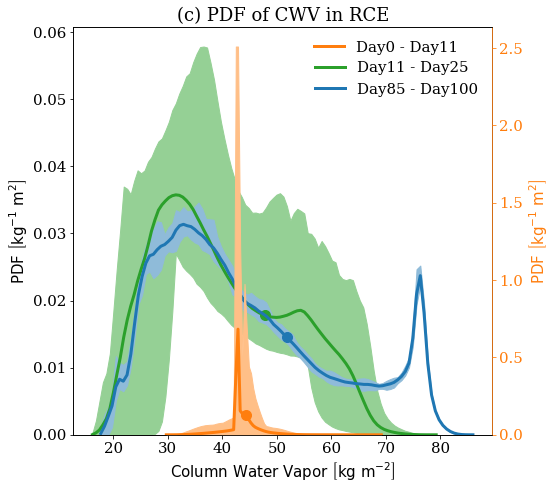

In [167]:
fig,ax = plt.subplots(figsize=(7.5,7.5))

# Figure 1a
ax2 = ax.twinx()

# Shading goes in the back
ax2.fill_between(edgTObin(F1c.SPINedges),F1c.SPIN_min,F1c.SPIN_max,color=1-(1-F1c.SPINrgb)/2)
ax.fill_between(edgTObin(F1c.COALedges),F1c.COAL_min,F1c.COAL_max,color=1-(1-F1c.COALrgb)/2)
ax.fill_between(edgTObin(F1c.COARedges),F1c.COAR_min,F1c.COAR_max,color=1-(1-F1c.COARrgb)/2)

# Right axis = Day 11-100
SPINline = ax2.plot(edgTObin(F1c.SPINedges),F1c.CWV_PDF_SPIN,color=F1c.SPINrgb,label='Day0 - Day11')
# Add dots to indicate mean value of percentile chosen for MMLi
ax2.scatter(x=F1c.SPIN_P48_mean,y=np.interp(x=F1c.SPIN_P48_mean,xp=edgTObin(F1c.SPINedges),fp=F1c.CWV_PDF_SPIN),color=F1c.SPINrgb)

ax2.set_ylabel(r'$\mathrm{PDF\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$',color=F1c.SPINrgb)
ax2.spines['right'].set_color(F1c.SPINrgb)
ax2.tick_params(axis='y', colors=F1c.SPINrgb)
ax2.set_ylim((0,ax2.get_ylim()[1]))
leg2 = ax2.legend(frameon=False,bbox_to_anchor=(0,0,0.95,1))

# Left axis = Day0-Day11
COALline = ax.plot(edgTObin(F1c.COALedges),F1c.CWV_PDF_COAL,color=F1c.COALrgb,label='Day11 - Day25')
COARline = ax.plot(edgTObin(F1c.COARedges),F1c.CWV_PDF_COAR,color=F1c.COARrgb,label='Day85 - Day100')
# Add dots to indicate mean value of percentile chosen for MMLi
ax.scatter(x=F1c.COAL_P48_mean,y=np.interp(x=F1c.COAL_P48_mean,xp=edgTObin(F1c.COALedges),fp=F1c.CWV_PDF_COAL),color=F1c.COALrgb)
ax.scatter(x=F1c.COAR_P48_mean,y=np.interp(x=F1c.COAR_P48_mean,xp=edgTObin(F1c.COARedges),fp=F1c.CWV_PDF_COAR),color=F1c.COARrgb)

leg = ax.legend(frameon=False,bbox_to_anchor=(0,0,1,0.95))
ax.set_xlabel(r'$\mathrm{Column\ Water\ Vapor\ }\left[\mathrm{kg\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{PDF\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$')
ax.set_ylim((0,ax.get_ylim()[1]))
ax.set_title('(c) PDF of CWV in RCE')

plt.draw()

# Save figure
path_home = '/users/tbeucler/'
plt.savefig(path_home+'Fig1.pdf',format='pdf')

## 1.2) ERA5 Reanalysis

### 1.2.1) Figure 1b = Time-mean column water vapor field

#### Make Figure

In [40]:
path_ERA = '/project/s916/ERA5_Tom/'

In [41]:
latmin = -23
latmax = 23
lonmin = 360-34
lonmax = 360-18

In [42]:
date1, date2 = np.datetime64('2000-01-01T00:00'), np.datetime64('2017-12-31T23:00')

In [43]:
thresh = 83 #48mm in percentile

In [44]:
PW = xr.open_mfdataset(path_ERA+'????/??PW.nc',combine='by_coords')
PWAtl = PW['tcwv'].sel({'time':slice(date1, date2), 'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})
lonAtl = PW.longitude.sel({'longitude':slice(lonmin,lonmax)})
latAtl = PW.latitude.sel({'latitude':slice(latmax,latmin)})

In [53]:
#PWAtl_mean = PWAtl.mean('time').values
hf = open(pathPKL+'2020_01_08_ERA5_CWV.pkl','rb')
PWAtl_mean = pickle.load(hf)['toplot']

tgb - 1/20/2020 - Add 83rd percentile of FMSE to Figure 1b

In [54]:
PW_p83 = np.percentile(PWAtl,83)

In [55]:
PW_p83

48.659915924072266

Back to plotting

In [45]:
time_A = PWAtl.time.values

In [176]:
LSM = xr.open_mfdataset(path_ERA+'ERA_LANDSEAMASK.nc')
LSMAtl = LSM['lsm'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})

/users/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/users/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [177]:
# Calculate Area of domain assuming a rectangle (since we assumed constant dx for the contour)
dx = 110/4 #km
A_domain = PWAtl.shape[1]*PWAtl.shape[2]*(dx**2) #km**2
L_band = 2.0*PWAtl.shape[2]*dx
circle_sw = False

In [178]:
year = 2009
YEAR = np.arange(2000,2018)# np.append(np.arange(2000,2014), np.arange(2015,2018)) #2014 is missing!

AxesSubplot(0.125,0.125;0.775x0.755)


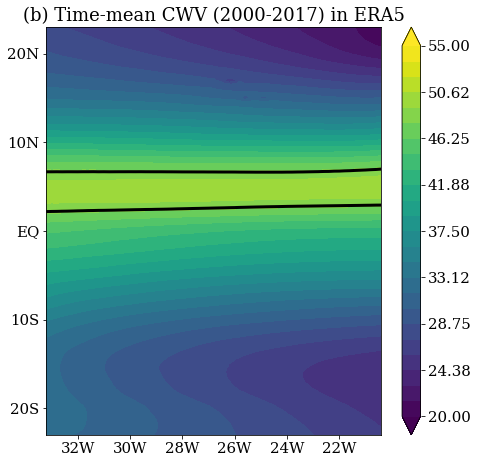

In [179]:
# Multi-year mean of CWV 
fig, axes = plt.subplots(1,1,figsize=(7.5,7.5))

print(axes)

tmp = PWAtl_mean

axes.contour(lonAtl, latAtl, tmp, [48.00], colors=['k'])#, vmin = 2.7e9, vmax=2.85e9)
cont_levels = np.linspace(20,55,25)
im = axes.contourf(lonAtl, latAtl, tmp, cont_levels, vmin = 20, vmax = 55, extend='both')

locs = axes.get_xticks()
labels = list(np.arange(len(locs)))
for i_l, loc in enumerate(locs):
    labels[i_l] = '%iW'%int(360-loc)
axes.set_xticklabels(labels) 

locs = axes.get_yticks()
labels = list(np.arange(len(locs)))
for i_l, loc in enumerate(locs):
    if loc >0:
        labels[i_l] = '%iN'%int(loc)
    elif loc == 0:
        labels[i_l] = 'EQ'
    else:
        labels[i_l] = '%iS'%int(loc*-1)
axes.set_yticklabels(labels)
axes.set_title('(b) Time-mean CWV (2000-2017) in ERA5')

cbar = plt.colorbar(im)

#### Save reduced data

In [180]:
hf = open(pathPKL+'2020_01_08_ERA5_CWV.pkl','wb')

In [181]:
F1b_data={'lon':lonAtl,'lat':latAtl,
          'toplot':tmp}

In [182]:
pickle.dump(F1b_data,hf)
hf.close()

#### Make Figure from reduced data

In [185]:
# Load reduced data into dictionary S
pathPKL = '/users/tbeucler/2019_WMI/dev/tbeucler/PKL_DATA/'
path = pathPKL+'2020_01_08_ERA5_CWV.pkl'
hf = open(path,'rb')
S = pickle.load(hf)
F1b = Bunch(S)

AxesSubplot(0.125,0.125;0.775x0.755)


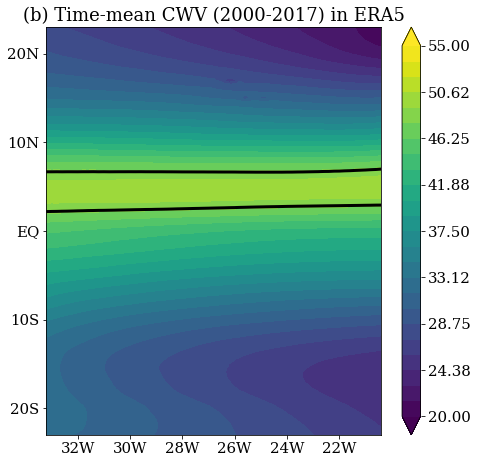

In [186]:
# Multi-year mean of CWV 
fig, axes = plt.subplots(1,1,figsize=(7.5,7.5))

print(axes)

tmp = PWAtl_mean

axes.contour(F1b.lon,F1b.lat,F1b.toplot, [48.00], colors=['k'])#, vmin = 2.7e9, vmax=2.85e9)
cont_levels = np.linspace(20,55,25)
im = axes.contourf(F1b.lon,F1b.lat,F1b.toplot, cont_levels, vmin = 20, vmax = 55, extend='both')

locs = axes.get_xticks()
labels = list(np.arange(len(locs)))
for i_l, loc in enumerate(locs):
    labels[i_l] = '%iW'%int(360-loc)
axes.set_xticklabels(labels) 

locs = axes.get_yticks()
labels = list(np.arange(len(locs)))
for i_l, loc in enumerate(locs):
    if loc >0:
        labels[i_l] = '%iN'%int(loc)
    elif loc == 0:
        labels[i_l] = 'EQ'
    else:
        labels[i_l] = '%iS'%int(loc*-1)
axes.set_yticklabels(labels)
axes.set_title('(b) Time-mean CWV (2000-2017) in ERA5')

cbar = plt.colorbar(im)

### 1.2.2) Figure 1d = PDF of column water vapor for ERA

#### Make Figure

In [1]:
nbins = 30
xbins = np.linspace(10, 70, 31)

NameError: name 'np' is not defined

In [2]:
path_JuliaPKL = '/users/tbeucler/2019_WMI/dev/jwindmiller/PKL_DATA/'
dic_hist = np.load(path_JuliaPKL+'CWV_hist_%i_%i_%i_%i_%i.npz'%(nbins, latmin, latmax, lonmin, lonmax))

hist_total = dic_hist['hist_total']
bin_edges = dic_hist['bin_edges']

NameError: name 'np' is not defined

In [205]:
hist_cum = np.cumsum(hist_total)/np.sum(hist_total)

In [206]:
hist_total = hist_total/np.sum(hist_total)/(bin_edges[1]-bin_edges[0])

In [207]:
with open(path_JuliaPKL+'pik_times.dat', 'rb') as f:
    times_A = pickle.load(f)
times_A

[numpy.datetime64('2005-11-23T14:00:00.000000000'),
 numpy.datetime64('2005-12-04T14:00:00.000000000'),
 numpy.datetime64('2005-12-07T14:00:00.000000000')]

Modify times_A so that times_A[1] coincides with the minimum in contour length

In [208]:
#times_A[1] = np.datetime64('2005-12-02T17:00:00.000000000')

Plot Figure

In [209]:
switch_kde = False
method = 'KDE' if switch_kde else 'PDF'

1.0000000000000002
0.9999999999999999
0.9999999999999999


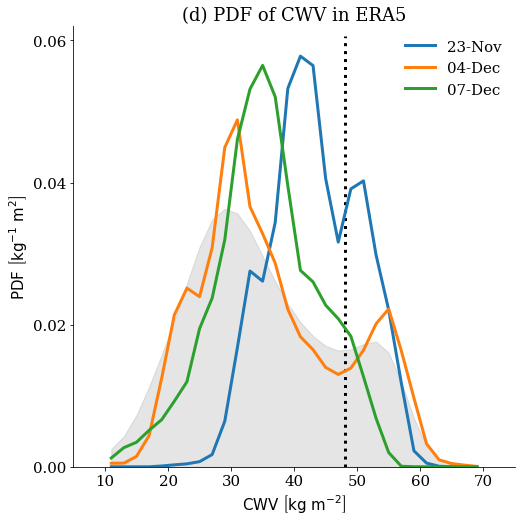

In [221]:
plt.close('all')

fig,ax = plt.subplots(figsize=(7.5,7.5))

x = np.linspace(10,75,161)

for i, time in enumerate(times_A):

    tmp = np.squeeze(PWAtl.sel({'time':slice(time-np.timedelta64(12,'h'), time+np.timedelta64(12,'h'))}).values) #np.squeeze(PWAtl.sel({'time':time}).values) #
    
    if switch_kde:
        density = stats.gaussian_kde(np.ndarray.flatten(tmp))
        plt.plot(x, density(x), label = pd.to_datetime(time).strftime("%d-%b"), color = col_A[i])
    else:
        hist, edges = np.histogram(np.ndarray.flatten(tmp), density = True, bins = xbins)
        plt.plot(edgTObin(edges), hist, label = pd.to_datetime(time).strftime("%d-%b"), color = col_A[i])
        print(np.sum(hist*(edges[1:]-edges[:-1])))
    
    plt.legend(frameon=False)
    #plt.vlines([np.percentile(tmp, per_thresh_era5)], 0.0, ymax, linestyle=':', color = 'C%i'%i)
    
#plt.plot(bin_centers, hist_total, 'k')
plt.fill_between(edgTObin(edges),hist_total, color = 'k',label='85d-100d', alpha = 0.1)
    
ymin, ymax = plt.ylim()
plt.vlines([48], 0.0, ymax, linestyle=':')
plt.ylim(0.0, 0.062)
plt.yticks([0.0, 0.02, 0.04, 0.06])
plt.xlim(xbins[0]-5, xbins[-1]+5)

ax.set_xlabel(r'$\mathrm{CWV}$ $\left[\mathrm{kg\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{%s\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$'%method)
ax.set_title('(d) PDF of CWV in ERA5')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.set_title('b)', loc = 'left')
    
plt.tight_layout()

#plt.savefig('./Figures/Fig1b.pdf', bbox_inches = "tight")

#### Save Reduced Data

In [211]:
hf = open(pathPKL+'2020_01_08_ERA5_PDF.pkl','wb')

In [212]:
F1d_data={'times_A':times_A,'CWV':PWAtl,
         'perc_thresh':thresh,'col_A':col_A,
         'edges':edges,'hist':hist,
          'hist_total':hist_total,
          'nbins':nbins,'xbins':xbins}

In [213]:
pickle.dump(F1d_data,hf)
hf.close()

#### Make Figure from reduced data

In [16]:
# Load reduced data into dictionary S
pathPKL = '/users/tbeucler/2019_WMI/dev/tbeucler/PKL_DATA/'
path = pathPKL+'2020_01_08_ERA5_PDF.pkl'
hf = open(path,'rb')
S = pickle.load(hf)
F1d = Bunch(S)

In [17]:
switch_kde = False
method = 'KDE' if switch_kde else 'PDF'

In [18]:
F1d.times_A

[numpy.datetime64('2005-11-23T14:00:00.000000000'),
 numpy.datetime64('2005-12-04T14:00:00.000000000'),
 numpy.datetime64('2005-12-07T14:00:00.000000000')]

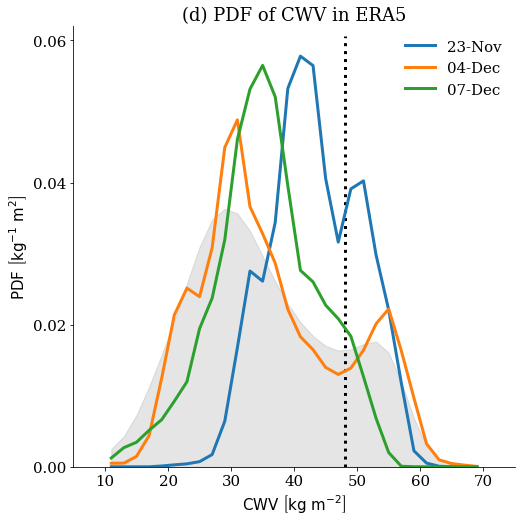

In [19]:
plt.close('all')

fig,ax = plt.subplots(figsize=(7.5,7.5))

x = np.linspace(10,75,161)

for i, time in enumerate(F1d.times_A):

    tmp = np.squeeze(F1d.CWV.sel({'time':slice(time-np.timedelta64(12,'h'),
                                               time+np.timedelta64(12,'h'))}).values) #np.squeeze(PWAtl.sel({'time':time}).values) #
    
    if switch_kde:
        density = stats.gaussian_kde(np.ndarray.flatten(tmp))
        plt.plot(x, density(x), label = pd.to_datetime(time).strftime("%d-%b"), color = F1d.col_A[i])
    else:
        hist, edges = np.histogram(np.ndarray.flatten(tmp), density = True, bins = F1d.xbins)
        plt.plot(edgTObin(edges), hist, label = pd.to_datetime(time).strftime("%d-%b"), color = F1d.col_A[i])
    
    plt.legend(frameon=False)
    
plt.fill_between(edgTObin(F1d.edges),F1d.hist_total, color = 'k',label='85d-100d', alpha = 0.1)
    
ymin, ymax = plt.ylim()
plt.vlines([48], 0.0, ymax, linestyle=':')
plt.ylim(0.0, 0.062)
plt.yticks([0.0, 0.02, 0.04, 0.06])
plt.xlim(F1d.xbins[0]-5, F1d.xbins[-1]+5)

ax.set_xlabel(r'$\mathrm{CWV}$ $\left[\mathrm{kg\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{%s\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$'%method)
ax.set_title('(d) PDF of CWV in ERA5')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
plt.tight_layout()

## 1.3) Add missing pieces for revisions: Time-averaged PDF and waterfall diagram

In [20]:
hist = {}
edges = {}

In [21]:
for i, time in enumerate(F1d.times_A):
    print('i=',i,'time=',time)
    tmp = np.squeeze(F1d.CWV.sel({'time':slice(time-np.timedelta64(24,'h'),
                                               time+np.timedelta64(24,'h'))}).values) #np.squeeze(PWAtl.sel({'time':time}).values) #
    hist[time], edges[time] = np.histogram(np.ndarray.flatten(tmp), density = True, bins = F1d.xbins)

i= 0 time= 2005-11-23T14:00:00.000000000
i= 1 time= 2005-12-04T14:00:00.000000000
i= 2 time= 2005-12-07T14:00:00.000000000


In [22]:
tmp = np.squeeze(F1d.CWV.sel({'time':slice(F1d.times_A[0]-np.timedelta64(24,'h'),
                                           F1d.times_A[-1]+np.timedelta64(24,'h'))}).values)
hist['all'],edges['all'] = np.histogram(np.ndarray.flatten(tmp), density = True, bins = F1d.xbins)

In [23]:
F1d.times_A[0]

numpy.datetime64('2005-11-23T14:00:00.000000000')

In [24]:
F1d.times_A[-1]

numpy.datetime64('2005-12-07T14:00:00.000000000')

In [25]:
import pandas as pd

date0 = pd.DatetimeIndex(['2005-11-23','2005-12-07'])
date0[1]-date0[0]

Timedelta('14 days 00:00:00')

In [52]:
pdf = np.zeros((14*24+20*24,30))
for it in range(14*24+20*24):
    t_base = F1d.times_A[0]+it*np.timedelta64(1,'h')-np.timedelta64(10*24,'h')
    if it==0: time_pdf = [t_base]
    else: time_pdf = np.concatenate((time_pdf,[t_base]))
    print(it,'/',str(34*24),t_base,end='\r')
    t_beg = t_base-np.timedelta64(24,'h')
    t_end = t_base+np.timedelta64(24,'h')
    tmp = np.squeeze(F1d.CWV.sel({'time':slice(t_beg,t_end)}).values)
    pdf[it,:],edg = np.histogram(np.ndarray.flatten(tmp), density = True, bins = F1d.xbins)

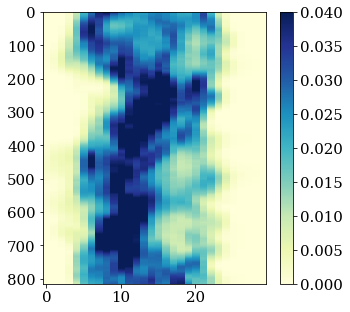

In [53]:
plt.figure(figsize=(5,5))
plt.imshow(pdf,cmap='YlGnBu',aspect='auto',vmin=0,vmax=0.04)
plt.colorbar()

In [54]:
# Save reduced data
pathPKL = '/users/tbeucler/2019_WMI/dev/tbeucler/PKL_DATA/'
hf = open(pathPKL+'2020_05_27_Fig1df.pkl','wb')
Fig1a = {"hist" : hist,
         "edges" : edges,
         "pdf" : pdf,
         "time_pdf": time_pdf
        }
pickle.dump(Fig1a,hf)
hf.close()

## 1.4) Combine all subplots into single Figure

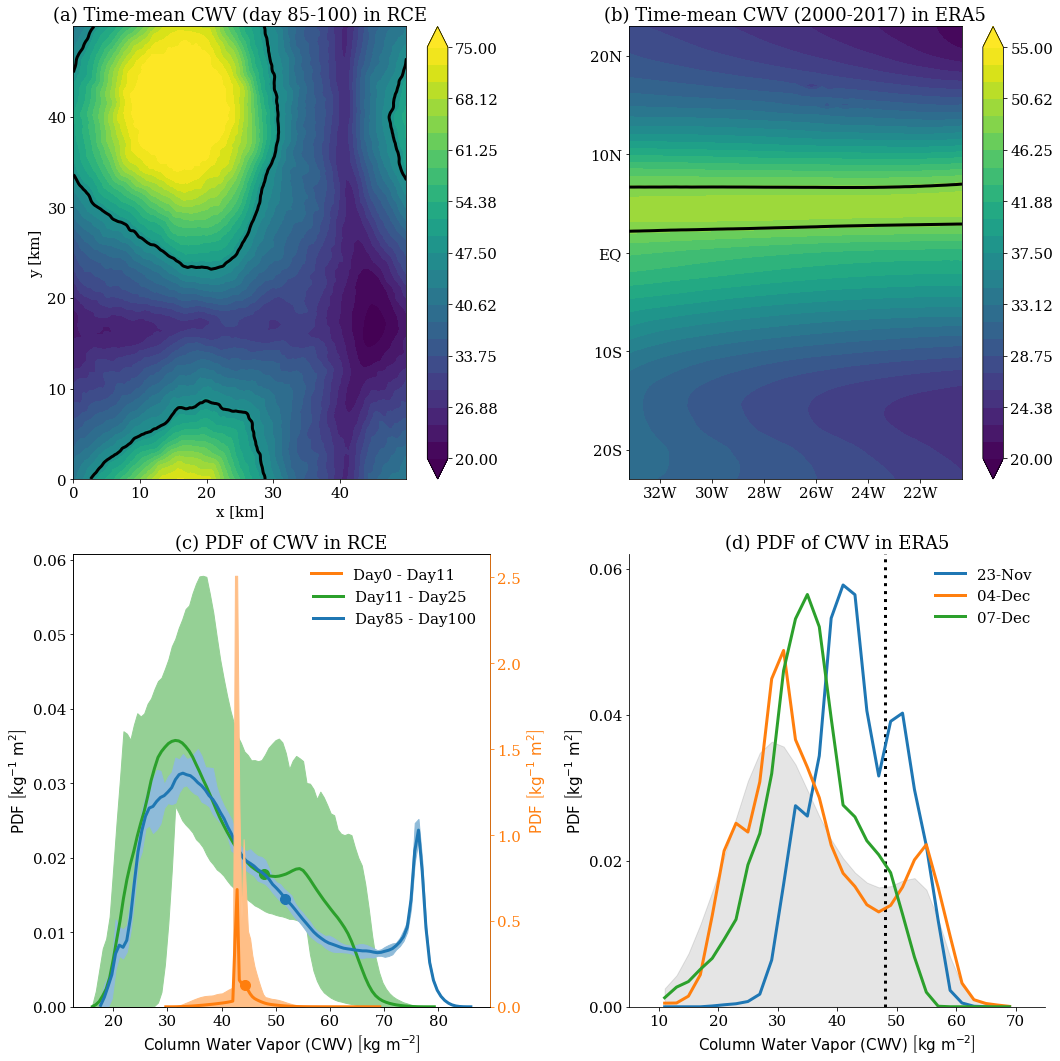

In [236]:
### Figure 1a
fig,ax0 = plt.subplots(2,2,figsize=(15,15))

ax = ax0[0][0]
ax.contour(F1a.x,F1a.y,F1a.toplot,[48.00],colors='k')
cont_levels = np.linspace(20,75,25)
im = ax.contourf(F1a.x, F1a.y, F1a.toplot, cont_levels, vmin = 20, vmax = 75, extend='both')
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_title('(a) Time-mean CWV (day 85-100) in RCE')
cbar = fig.colorbar(im,ax=ax)

### Figure 1c
ax = ax0[1][0]
ax2 = ax.twinx()

# Shading goes in the back
ax2.fill_between(edgTObin(F1c.SPINedges),F1c.SPIN_min,F1c.SPIN_max,color=1-(1-F1c.SPINrgb)/2)
ax.fill_between(edgTObin(F1c.COALedges),F1c.COAL_min,F1c.COAL_max,color=1-(1-F1c.COALrgb)/2)
ax.fill_between(edgTObin(F1c.COARedges),F1c.COAR_min,F1c.COAR_max,color=1-(1-F1c.COARrgb)/2)

# Right axis = Day 11-100
SPINline = ax2.plot(edgTObin(F1c.SPINedges),F1c.CWV_PDF_SPIN,color=F1c.SPINrgb,label='Day0 - Day11')
# Add dots to indicate mean value of percentile chosen for MMLi
ax2.scatter(x=F1c.SPIN_P48_mean,y=np.interp(x=F1c.SPIN_P48_mean,xp=edgTObin(F1c.SPINedges),fp=F1c.CWV_PDF_SPIN),color=F1c.SPINrgb)

ax2.set_ylabel(r'$\mathrm{PDF\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$',color=F1c.SPINrgb)
ax2.spines['right'].set_color(F1c.SPINrgb)
ax2.tick_params(axis='y', colors=F1c.SPINrgb)
ax2.set_ylim((0,ax2.get_ylim()[1]))
leg2 = ax2.legend(frameon=False,bbox_to_anchor=(0,0,0.95,1))

# Left axis = Day0-Day11
COALline = ax.plot(edgTObin(F1c.COALedges),F1c.CWV_PDF_COAL,color=F1c.COALrgb,label='Day11 - Day25')
COARline = ax.plot(edgTObin(F1c.COARedges),F1c.CWV_PDF_COAR,color=F1c.COARrgb,label='Day85 - Day100')
# Add dots to indicate mean value of percentile chosen for MMLi
ax.scatter(x=F1c.COAL_P48_mean,y=np.interp(x=F1c.COAL_P48_mean,xp=edgTObin(F1c.COALedges),fp=F1c.CWV_PDF_COAL),color=F1c.COALrgb)
ax.scatter(x=F1c.COAR_P48_mean,y=np.interp(x=F1c.COAR_P48_mean,xp=edgTObin(F1c.COARedges),fp=F1c.CWV_PDF_COAR),color=F1c.COARrgb)

leg = ax.legend(frameon=False,bbox_to_anchor=(0,0,1,0.95))
ax.set_xlabel(r'$\mathrm{Column\ Water\ Vapor\ \left(CWV\right)\ }\left[\mathrm{kg\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{PDF\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$')
ax.set_ylim((0,ax.get_ylim()[1]))
ax.set_title('(c) PDF of CWV in RCE')

### Figure 1b
# Multi-year mean of CWV 
axes = ax0[0][1]

tmp = PWAtl_mean

axes.contour(F1b.lon,F1b.lat,F1b.toplot, [48.00], colors=['k'])#, vmin = 2.7e9, vmax=2.85e9)
cont_levels = np.linspace(20,55,25)
im = axes.contourf(F1b.lon,F1b.lat,F1b.toplot, cont_levels, vmin = 20, vmax = 55, extend='both')

locs = axes.get_xticks()
labels = list(np.arange(len(locs)))
for i_l, loc in enumerate(locs):
    labels[i_l] = '%iW'%int(360-loc)
axes.set_xticklabels(labels) 

locs = axes.get_yticks()
labels = list(np.arange(len(locs)))
for i_l, loc in enumerate(locs):
    if loc >0:
        labels[i_l] = '%iN'%int(loc)
    elif loc == 0:
        labels[i_l] = 'EQ'
    else:
        labels[i_l] = '%iS'%int(loc*-1)
axes.set_yticklabels(labels)
axes.set_title('(b) Time-mean CWV (2000-2017) in ERA5')

cbar = fig.colorbar(im,ax=axes)

### Figure 1d

ax = ax0[1][1]
x = np.linspace(10,75,161)

for i, time in enumerate(F1d.times_A):

    tmp = np.squeeze(F1d.CWV.sel({'time':slice(time-np.timedelta64(12,'h'),
                                               time+np.timedelta64(12,'h'))}).values) #np.squeeze(PWAtl.sel({'time':time}).values) #
    
    if switch_kde:
        density = stats.gaussian_kde(np.ndarray.flatten(tmp))
        ax.plot(x, density(x), label = pd.to_datetime(time).strftime("%d-%b"), color = F1d.col_A[i])
    else:
        hist, edges = np.histogram(np.ndarray.flatten(tmp), density = True, bins = F1d.xbins)
        ax.plot(edgTObin(edges), hist, label = pd.to_datetime(time).strftime("%d-%b"), color = F1d.col_A[i])
    
    ax.legend(frameon=False)
    
ax.fill_between(edgTObin(F1d.edges),F1d.hist_total, color = 'k',label='85d-100d', alpha = 0.1)
    
ymin, ymax = plt.ylim()
ax.vlines([48], 0.0, ymax, linestyle=':')
ax.set_ylim(0.0, 0.062)
ax.set_yticks([0.0, 0.02, 0.04, 0.06])
ax.set_xlim(F1d.xbins[0]-5, F1d.xbins[-1]+5)

ax.set_xlabel(r'$\mathrm{Column\ Water\ Vapor\ \left(CWV\right)\ }\left[\mathrm{kg\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{%s\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$'%method)
ax.set_title('(d) PDF of CWV in ERA5')

#ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
plt.tight_layout()

# Save figure
path_home = '/users/tbeucler/'
plt.savefig(path_home+'Fig1.pdf',format='pdf')

# 2) Figure 2

## 2.1) COSMO simulations

### Make figure

In [10]:
RCE300 = xr.open_mfdataset(path_RCE+'lfff????????.nc', chunks={'time':100})

/users/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/users/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [11]:
dt = 3600; # Timestep in seconds
tcoor = dt*np.arange(0,RCE300.time.shape[0])

t_range = np.arange(0,np.size(RCE300.time)-2)
dPW_dt = (RCE300.TQV.values[t_range+2,:,:]-RCE300.TQV.values[t_range,:,:])/(2*dt)
dPW_dt = np.concatenate((dPW_dt[0:1,:,:],dPW_dt,np.tile(dPW_dt[-1,:,:],(1,1,1))),axis=0)

bin0=np.percentile(a=RCE300.TQV[-24*7:,:,:],q=50,axis=(0,1,2))

tmp,binm,V = Landau.Landau_energy(RCE300.TQV,dPW_dt,bin0,N_bins=30)

In [12]:
dbin = (binm[1:]-binm[:-1])[0]
binc = binm-0.5*dbin
binc = np.append(binc, binc[-1]+dbin)

In [13]:
Ffinal_RCE,binm_Ffinal_RCE,tmp = Landau.Landau_energy(RCE300.TQV.values,N_bins=30,V_fixed=V,bin_fixed=binm)

In [14]:
SPINstart = 0 #days
COALstart = 11 #days
COARstart = 25 #days
ENDstart = 85 # days

In [15]:
CWV_PDF_SPIN,SPINedges = np.histogram(RCE300.TQV[:(24*COALstart),:,:],bins=binc,density=True)
CWV_PDF_COAL,COALedges = np.histogram(RCE300.TQV[(24*COALstart):(24*COARstart),:,:],bins=binc,density=True)
CWV_PDF_COAR,COARedges = np.histogram(RCE300.TQV[(24*ENDstart):,:,:],bins=binc,density=True)

tgb - 1/20/2020 - Find values of the 88th percentile for each time-period

In [16]:
SPIN_p88 = np.percentile(RCE300.TQV[:(24*COALstart),:,:],88)
COAL_p88 = np.percentile(RCE300.TQV[(24*COALstart):(24*COARstart),:,:],88)
COAR_p88 = np.percentile(RCE300.TQV[(24*ENDstart):,:,:],88)

In [17]:
iSPIN = np.argmin(np.abs(edgTObin(SPINedges)-SPIN_p88))
PDF_SPIN = CWV_PDF_SPIN[iSPIN]
SPIN_p88 = np.array([SPIN_p88,PDF_SPIN,iSPIN])

In [18]:
iCOAL = np.argmin(np.abs(edgTObin(COALedges)-COAL_p88))
PDF_COAL = CWV_PDF_COAL[iCOAL]
COAL_p88 = np.array([COAL_p88,PDF_COAL,iCOAL])

In [19]:
iCOAR = np.argmin(np.abs(edgTObin(COARedges)-COAR_p88))
PDF_COAR = CWV_PDF_COAR[iCOAR]
COAR_p88 = np.array([COAR_p88,PDF_COAR,iCOAR])

Repeat for all three periods and concatenate at the end of the p88 vector

In [37]:
pathPKL = '/users/tbeucler/2019_WMI/dev/tbeucler/PKL_DATA/'
hf = open(pathPKL+'2020_01_20_p88.pkl','wb')

In [38]:
F2_data = {
    'SPIN_p88':SPIN_p88,
    'COAL_p88':COAL_p88,
    'COAR_p88':COAR_p88
}

In [39]:
pickle.dump(F2_data,hf)
hf.close()

Back to calculating the contour's length

In [20]:
dx = 3.3e3
CL = np.zeros((np.size(tcoor),))

perc_thresh_RCE = 88

for it,t in enumerate(tcoor):
    print('it=',it,'           ',end='\r')
    CWV_tmp = RCE300.TQV[it,:,:]
    
    CWV_binary = np.zeros(np.shape(CWV_tmp))
    CWV_binary[CWV_tmp>np.percentile(RCE300.TQV[it,:,:], perc_thresh_RCE)] = 1

    binary_boundary=np.copy(CWV_binary)
    binary_boundary[:,1:-1]=0

    L = dx*(measure.perimeter(CWV_binary,8)- np.sum(binary_boundary))
        
    CL[it] = L

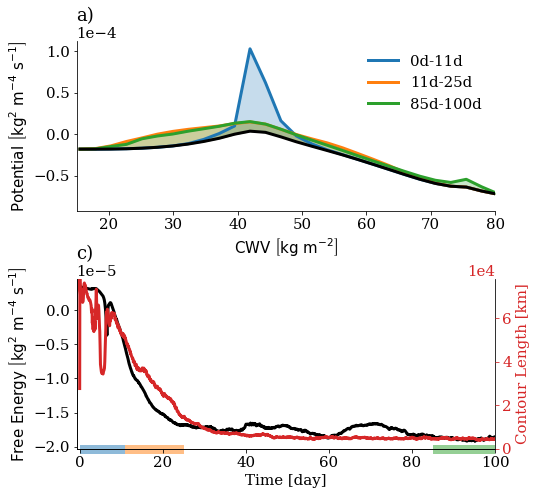

In [246]:
fig,ax = plt.subplots(2,1,figsize=(7.5,7.5))
plt.subplots_adjust(hspace=0.33)

ax[0].set_xlim((15,80))
# ax[0].set_ylim((-1.5e8,1e9))
ax[0].set_title('a)',loc = 'left', pad=20)
ax[0].set_xlabel(r'$\mathrm{CWV}\ \left[\mathrm{kg\ m^{-2}}\right]$')
ax[0].set_ylabel(r'$\mathrm{Potential\ \left[kg^{2}\ m^{-4}\ s^{-1}\right]}$')

ax[0].fill_between((edgTObin(SPINedges)),V,V+CWV_PDF_SPIN*5e-4,color=col_A[0], alpha = 0.25)
ax[0].fill_between((edgTObin(COALedges)),V,V+CWV_PDF_COAL*5e-4,color=col_A[1], alpha = 0.25)
ax[0].fill_between((edgTObin(COARedges)),V,V+CWV_PDF_COAR*5e-4,color=col_A[2], alpha = 0.25)


ax[0].plot((edgTObin(SPINedges)),V+CWV_PDF_SPIN*5e-4,color=col_A[0],label='0d-11d')
ax[0].plot((edgTObin(COALedges)),V+CWV_PDF_COAL*5e-4,color=col_A[1],label='11d-25d')
ax[0].plot((edgTObin(COARedges)),V+CWV_PDF_COAR*5e-4,color=col_A[2],label='85d-100d')
ax[0].legend(frameon=False,loc='upper right')

ax[0].plot(binm,V,color='k')

axbis = ax[1].twinx()
axbis.plot(tcoor/(24*3600),CL/1e3,color='C3')

ymin_C, ymax_C = 0, np.max(CL)/1e3

axbis.spines['right'].set_color('C3')
axbis.tick_params(axis='y', colors='C3')
axbis.set_ylim((ymin_C, ymax_C))
axbis.set_ylabel('Contour Length [km]',color='C3')

ax[0].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)

ax[0].spines['right'].set_visible(False)
axbis.spines['right'].set_visible(False)

ax[1].plot(tcoor/(24*3600),Ffinal_RCE,color='k')
ymin_F, ymax_F = ax[1].get_ylim()

# From https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/fill_between_demo.html
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax[1].transData, ax[1].transAxes)
period_y_max, period_y_min = -0.03, 0.02

ax[1].fill_between(x=tcoor/(24*3600),y1=period_y_min,y2=period_y_max,where=(tcoor/(24*3600)<=11)&(tcoor/(24*3600)>=0),
                   facecolor=col_A[0],alpha=0.5,transform=trans, clip_on=False)
ax[1].fill_between(x=tcoor/(24*3600),y1=period_y_min,y2=period_y_max,where=(tcoor/(24*3600)<=25)&(tcoor/(24*3600)>=11),
                   facecolor=col_A[1],alpha=0.5,transform=trans, clip_on=False)
ax[1].fill_between(x=tcoor/(24*3600),y1=period_y_min,y2=period_y_max,where=(tcoor/(24*3600)<=100)&(tcoor/(24*3600)>=85),
                   facecolor=col_A[2],alpha=0.5,transform=trans, clip_on=False)

ax[1].set_title('c)',loc='left', pad=20)
ax[1].set_xlim((-0.75,100))
ax[1].set_ylim((ymin_F, ymax_F))
ax[1].set_xlabel('Time [day]')
ax[1].set_ylabel(r'$\mathrm{Free\ Energy\ \left[kg^{2}\ m^{-4}\ s^{-1}\right]}$')

ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
axbis.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')

ax[1].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)


plt.subplots_adjust(hspace = 0.4)

### Save reduced data

In [249]:
hf = open(pathPKL+'2020_01_08_COSMO_LFE.pkl','wb')

In [250]:
F2a_data = {
    'SPINedges':SPINedges,'COALedges':COALedges,'COARedges':COARedges,
    'V':V,'CWV_PDF_SPIN':CWV_PDF_SPIN,'CWV_PDF_COAL':CWV_PDF_COAL,
    'CWV_PDF_COAR':CWV_PDF_COAR,'col_A':col_A,
    'binm':binm,'tcoor':tcoor,'CL':CL,
    'Ffinal_RCE':Ffinal_RCE
}

In [251]:
pickle.dump(F2a_data,hf)
hf.close()

### Make Figure from Reduced data

In [13]:
# Load reduced data into dictionary S
path = pathPKL+'2020_01_08_COSMO_LFE.pkl'
hf = open(path,'rb')
S = pickle.load(hf)
F2a = Bunch(S)

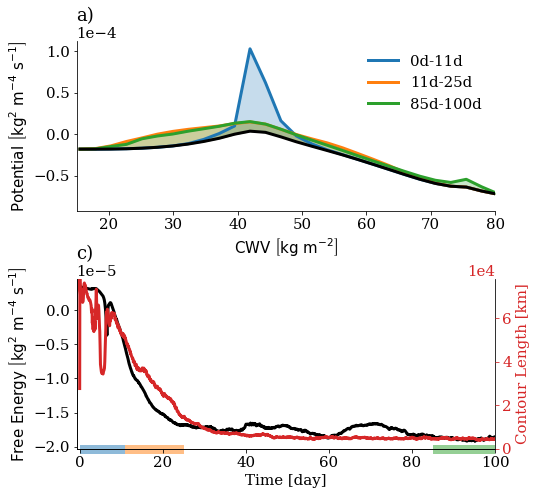

In [254]:
fig,ax = plt.subplots(2,1,figsize=(7.5,7.5))
plt.subplots_adjust(hspace=0.33)

ax[0].set_xlim((15,80))
# ax[0].set_ylim((-1.5e8,1e9))
ax[0].set_title('a)',loc = 'left', pad=20)
ax[0].set_xlabel(r'$\mathrm{CWV}\ \left[\mathrm{kg\ m^{-2}}\right]$')
ax[0].set_ylabel(r'$\mathrm{Potential\ \left[kg^{2}\ m^{-4}\ s^{-1}\right]}$')

ax[0].fill_between((edgTObin(F2a.SPINedges)),F2a.V,F2a.V+F2a.CWV_PDF_SPIN*5e-4,color=F2a.col_A[0], alpha = 0.25)
ax[0].fill_between((edgTObin(F2a.COALedges)),F2a.V,F2a.V+F2a.CWV_PDF_COAL*5e-4,color=F2a.col_A[1], alpha = 0.25)
ax[0].fill_between((edgTObin(F2a.COARedges)),F2a.V,F2a.V+F2a.CWV_PDF_COAR*5e-4,color=F2a.col_A[2], alpha = 0.25)


ax[0].plot((edgTObin(F2a.SPINedges)),F2a.V+F2a.CWV_PDF_SPIN*5e-4,color=F2a.col_A[0],label='0d-11d')
ax[0].plot((edgTObin(F2a.COALedges)),F2a.V+F2a.CWV_PDF_COAL*5e-4,color=F2a.col_A[1],label='11d-25d')
ax[0].plot((edgTObin(F2a.COARedges)),F2a.V+F2a.CWV_PDF_COAR*5e-4,color=F2a.col_A[2],label='85d-100d')
ax[0].legend(frameon=False,loc='upper right')

ax[0].plot(F2a.binm,F2a.V,color='k')

axbis = ax[1].twinx()
axbis.plot(F2a.tcoor/(24*3600),F2a.CL/1e3,color='C3')

ymin_C, ymax_C = 0, np.max(F2a.CL)/1e3

axbis.spines['right'].set_color('C3')
axbis.tick_params(axis='y', colors='C3')
axbis.set_ylim((ymin_C, ymax_C))
axbis.set_ylabel('Contour Length [km]',color='C3')

ax[0].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)

ax[0].spines['right'].set_visible(False)
axbis.spines['right'].set_visible(False)

ax[1].plot(F2a.tcoor/(24*3600),F2a.Ffinal_RCE,color='k')
ymin_F, ymax_F = ax[1].get_ylim()

# From https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/fill_between_demo.html
trans = mtransforms.blended_transform_factory(ax[1].transData, ax[1].transAxes)
period_y_max, period_y_min = -0.03, 0.02

ax[1].fill_between(x=F2a.tcoor/(24*3600),y1=period_y_min,y2=period_y_max,
                   where=(tcoor/(24*3600)<=11)&(tcoor/(24*3600)>=0),
                   facecolor=col_A[0],alpha=0.5,transform=trans, clip_on=False)
ax[1].fill_between(x=F2a.tcoor/(24*3600),y1=period_y_min,y2=period_y_max,
                   where=(tcoor/(24*3600)<=25)&(tcoor/(24*3600)>=11),
                   facecolor=col_A[1],alpha=0.5,transform=trans, clip_on=False)
ax[1].fill_between(x=F2a.tcoor/(24*3600),y1=period_y_min,y2=period_y_max,
                   where=(tcoor/(24*3600)<=100)&(tcoor/(24*3600)>=85),
                   facecolor=col_A[2],alpha=0.5,transform=trans, clip_on=False)

ax[1].set_title('c)',loc='left', pad=20)
ax[1].set_xlim((-0.75,100))
ax[1].set_ylim((ymin_F, ymax_F))
ax[1].set_xlabel('Time [day]')
ax[1].set_ylabel(r'$\mathrm{Free\ Energy\ \left[kg^{2}\ m^{-4}\ s^{-1}\right]}$')

ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
axbis.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')

ax[1].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)


plt.subplots_adjust(hspace = 0.4)

### Form effective Bond number

Estimate tau_MML via centered finite difference

In [49]:
tau_MML_m1 = (F2a.CL[2:]-F2a.CL[:-2])/(F2a.CL[1:-1]*3600)

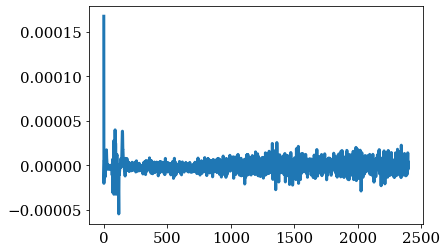

In [15]:
plt.plot(tau_MML)

In [43]:
tau_MML24_m1 = (F2a.CL[48:]-F2a.CL[:-48])/(F2a.CL[24:-24]*(48*3600))

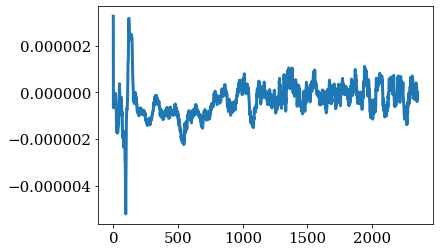

In [45]:
plt.plot(tau_MML24_m1)

Average both taus m1 over 10-day periods

In [69]:
tau_MML10d_m1 = (F2a.CL[10*24:]-F2a.CL[:-10*24])/(F2a.CL[5*24:-5*24]*(10*24*3600))

Estimate timescale via autocorrelation timescale

In [92]:
CL_autocor = np.correlate(F2a.CL,F2a.CL,mode='full')
CL_AC = CL_autocor[int(CL_autocor.size/2):]

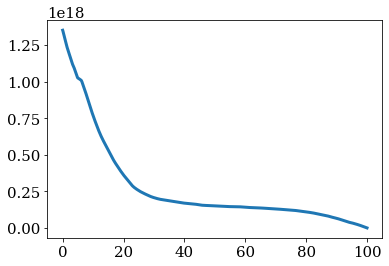

In [97]:
plt.plot(F2a.tcoor[:CL_AC.size]/(24*3600),CL_AC)

In [99]:
efold = (F2a.tcoor[:CL_AC.size]/(24*3600))[np.argmin(np.abs(CL_AC-np.max(CL_AC)/np.exp(1)))]

In [100]:
efold

15.833333333333334

e-folding timescale of autocorrelation function is 15 days

Estimate `V''` via centered finite difference

In [179]:
F2a.V

array([-1.80108631e-05, -1.80288320e-05, -1.79058485e-05, -1.75509117e-05,
       -1.68778566e-05, -1.57918806e-05, -1.41710162e-05, -1.18812276e-05,
       -8.78711339e-06, -4.93962453e-06,  0.00000000e+00,  3.66318300e-06,
        2.24857630e-06, -3.22230966e-06, -9.17244159e-06, -1.45062854e-05,
       -1.97049160e-05, -2.49899598e-05, -3.06240513e-05, -3.65113936e-05,
       -4.24966049e-05, -4.85402446e-05, -5.43416154e-05, -5.93272689e-05,
       -6.27149289e-05, -6.37624746e-05, -6.85203901e-05, -7.22661893e-05,
       -5.23557111e-05, -8.32507144e-05])

In [180]:
dbinm = np.mean(np.diff(F2a.binm))

In [181]:
print(dbinm,dbinm**2)

2.3992116 5.756216518109852


In [182]:
V_2 = (F2a.V[2:]-2*F2a.V[1:-1]+F2a.V[:-2])/dbinm**2

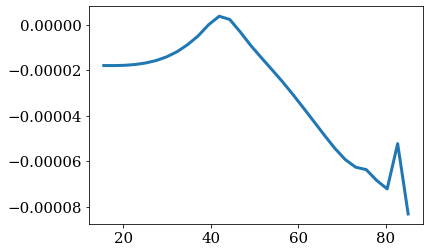

In [183]:
plt.plot(F2a.binm,F2a.V)

In [184]:
imin = np.argmin(F2a.V[:10])
imid = np.argmax(F2a.V)
imax = np.argmin(F2a.V[:29])
ind = [imin,imid,imax]
print(ind)
xind = F2a.binm[ind]
print(xind)
yind = F2a.V[ind]
print(yind)

[1, 11, 27]
[17.943916 41.936035 80.323425]
[-1.80288320e-05  3.66318300e-06 -7.22661893e-05]


In [185]:
dr = xind[-1]-xind[1]
dl = xind[0]-xind[1]
print(dl,dr)
print(dr-dl)
print(dl*(dr**2)-dr*(dl**2))

-23.992119 38.38739
62.37951
-57451.20500822587


In [186]:
V2_estimate = 2*(dl*yind[2]-dr*yind[0]+(dr-dl)*yind[1])/(dl*dr**2-dr*dl**2)

In [187]:
tau_V2 = -1/(24*3600*V2_estimate)
print(tau_V2)

125.25295886000528


In [188]:
C = np.polyfit(x=F2a.binm[imin:imax],y=F2a.V[imin:imax],deg=2)

In [189]:
C2 = np.polyfit(x=xind,y=yind,deg=2)

(-0.0001, 5e-05)

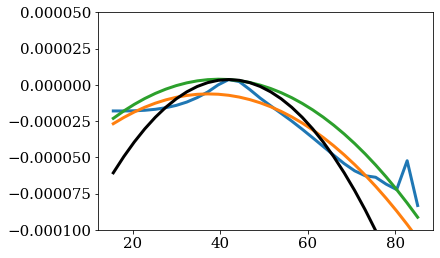

In [192]:
plt.plot(F2a.binm,F2a.V)
plt.plot(F2a.binm,C[0]*F2a.binm**2+C[1]*F2a.binm**1+C[2]*F2a.binm**0)
plt.plot(F2a.binm,C2[0]*F2a.binm**2+C2[1]*F2a.binm**1+C2[2]*F2a.binm**0)
plt.plot(F2a.binm,V2_estimate*(F2a.binm-F2a.binm[imid])**2+F2a.V[imid],color='k')
plt.ylim((-1e-4,0.5e-4))

In [193]:
print(tau_V2,-1/(24*3600*C[0]),-1/(24*3600*C2[0]))

125.25295886000528 265.64544630117933 250.5059177200103


(-0.1, 0.1)

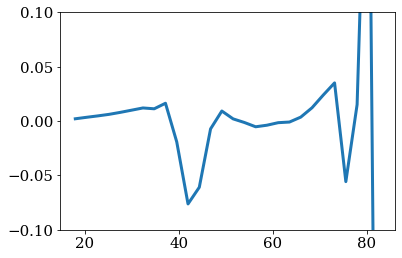

In [29]:
plt.plot(F2a.binm[1:-1],24*3600*V_2)
plt.ylim((-0.1,0.1))

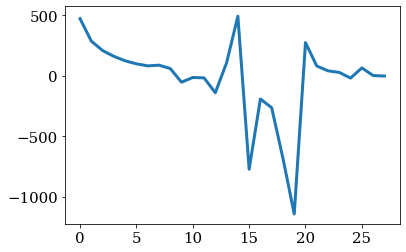

In [105]:
plt.plot(1/(24*3600*V_2))

In [106]:
V_2max = np.max(F2a.V[5:-5])

In [107]:
tau_V2 = 1/(V_2max)

In [108]:
tau_V2/(24*3600) # Quickest changes due to potential (in days)

3.1595675301140096

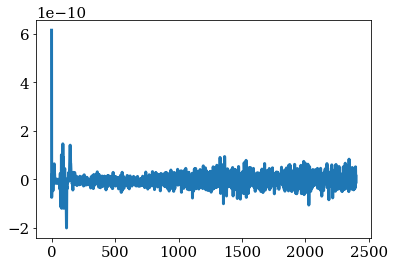

In [38]:
plt.plot(tau_MML/tau_V2)

## 2.2) ERA5 Reanalysis

### Make Figure

In [56]:
CONJUL_data = {}

path_PKL = '/users/tbeucler/2019_WMI/dev/jwindmiller/PKL_DATA/'

for i,year in enumerate(range(2000,2018)):
    print('i=',i,' & year=',year,' ',end='\r')
    hf = open(path_PKL+'CONTOURL_PW_%i_%i_%i_%i_%i_'%(latmin, latmax, lonmin, lonmax, thresh)+str(year)+'.pkl','rb') # open('../jwindmiller/PKL_DATA/10_17_CONTOURL'+str(year)+'.pkl','rb')
    tmp = pickle.load(hf)
    CONJUL_data[year] = tmp['Tot_Contour_km'][str(year)]
    
cont_t = np.array(get_all_values(CONJUL_data))

In [57]:
with open(path_PKL+'pik_times.dat', 'rb') as f:
    times_A = pickle.load(f)
times_A

[numpy.datetime64('2005-11-23T14:00:00.000000000'),
 numpy.datetime64('2005-12-04T14:00:00.000000000'),
 numpy.datetime64('2005-12-07T14:00:00.000000000')]

Find minimal contour between times_A[0] and times_A[2]

In [58]:
date1, date2 = np.datetime64('2005-01-01T00:00'), np.datetime64('2005-12-31T23:00')

In [61]:
time_period = time_A[np.where((time_A>times_A[0]-np.timedelta64(6,'h'))&(time_A<times_A[-1]+np.timedelta64(6,'h')))]
cont_period = cont_t[np.where((time_A>times_A[0]-np.timedelta64(6,'h'))&(time_A<times_A[-1]+np.timedelta64(6,'h')))]

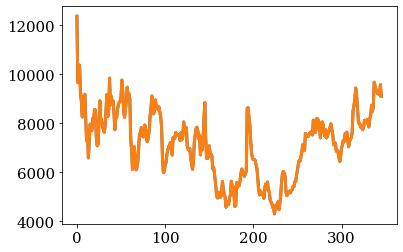

In [62]:
plt.plot(CONJUL_data[2005][7833:8179])
plt.plot(cont_t[((366+365+365+365+366)*24+7833):((366+365+365+365+366)*24+8179)])

In [63]:
it_min = np.argmin(cont_period)

In [64]:
it_min

224

/users/tbeucler/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


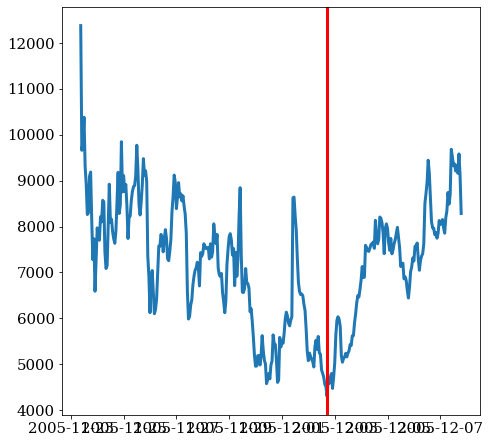

In [65]:
plt.figure(figsize=(7.5,7.5))
plt.plot(time_period,cont_period)
plt.axvline(x=time_period[it_min],color='r')

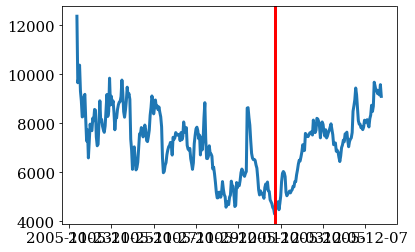

In [66]:
itA_min = (366+365+365+365+366)*24+7833+it_min
plt.plot(time_A[((366+365+365+365+366)*24+7833):((366+365+365+365+366)*24+8179)],cont_t[((366+365+365+365+366)*24+7833):((366+365+365+365+366)*24+8179)])
plt.axvline(x=time_A[itA_min],color='r')

In [67]:
time_A[itA_min]

numpy.datetime64('2005-12-02T17:00:00.000000000')

Modify times_A[1] accordingly

In [ ]:
times_A[1] = time_A[itA_min]

Calculate PW tendency, Potential, LFE

In [68]:
times_Vstart = times_A[0] 
times_Vend   = times_A[1] 

ileftV = find_index(time_A, np.datetime64(times_Vstart))
irightV = find_index(time_A, np.datetime64(times_Vend))

In [69]:
PWAtl_res = PWAtl[ileftV-1:irightV+2,:,:].values # If can't fit in the memory, can't calculate potential

In [70]:
dt = 3600
dPW_dt = (PWAtl_res[2:,:,:]-PWAtl_res[:-2,:,:])/(2*dt)

In [71]:
tmp,binm_Vfinal,Vfinal = Landau.Landau_energy(PWAtl_res[1:-1,:,:],dPW_dt,N_bins=50)

In [72]:
date_startF = times_A[0] 
date_endF   = times_A[-1]

ileftF = find_index(time_A, np.datetime64(date_startF))
irightF = find_index(time_A, np.datetime64(date_endF))
PWAtl_F = PWAtl[ileftF:irightF,:,:]
Ffinal,binm_Ffinal,tmp = Landau.Landau_energy(PWAtl_F.values,N_bins=30,V_fixed=Vfinal,bin_fixed=binm_Vfinal)

In [73]:
dbin_Vfinal = (binm_Vfinal[1:]-binm_Vfinal[:-1])[0]
binc_Vfinal = binm_Vfinal-0.5*dbin_Vfinal
binc_Vfinal = np.append(binc_Vfinal, binc_Vfinal[-1]+dbin_Vfinal)

In [74]:
dic_hist = {}
times_labels = pd.to_datetime(times_A).strftime("%d-%b")
times_year   = int(pd.to_datetime(times_A[0]).strftime("%Y"))

for i, time in enumerate(times_A):
    tmp = np.squeeze(PWAtl.sel({'time':slice(time-np.timedelta64(6,'h'), time+np.timedelta64(6,'h'))}).values)
    hist, edges = np.histogram(np.ndarray.flatten(tmp), density = True, bins = binc_Vfinal)
    
    dic_hist[times_labels[i]]=hist
    
dic_hist.keys()

dict_keys(['23-Nov', '04-Dec', '07-Dec'])

tgb  - 1/20/2020 - Find 83rd percentile for each time

In [79]:
perc83 = {}
PDF83 = {}

In [83]:
for i, time in enumerate(times_A):
    tmp = np.squeeze(PWAtl.sel({'time':slice(time-np.timedelta64(6,'h'), time+np.timedelta64(6,'h'))}).values)
    perc83[times_labels[i]] = np.percentile(tmp,83)
    itmp = np.argmin(np.abs(edgTObin(binc_Vfinal)-perc83[times_labels[i]]))
    PDF83[times_labels[i]] = dic_hist[times_labels[i]][itmp]

In [84]:
perc83

{'23-Nov': 50.82664520263672,
 '04-Dec': 50.778297424316406,
 '07-Dec': 43.78326416015625}

In [85]:
PDF83

{'23-Nov': 0.04120645192211918,
 '04-Dec': 0.01622986305440763,
 '07-Dec': 0.026934115426284006}

Save reduced data

In [89]:
pathPKL = '/users/tbeucler/2019_WMI/dev/tbeucler/PKL_DATA/'
hf = open(pathPKL+'2020_01_20_ERAp83.pkl','wb')

In [90]:
F2_data = {
    'perc83':perc83,
    'PDF83':PDF83
}

In [91]:
pickle.dump(F2_data,hf)
hf.close()

Make figure

2005-11-23T02:00:00.000000000 2005-11-24T02:00:00.000000000
12
2005-12-04T02:00:00.000000000 2005-12-05T02:00:00.000000000
13
2005-12-07T02:00:00.000000000 2005-12-08T02:00:00.000000000
12


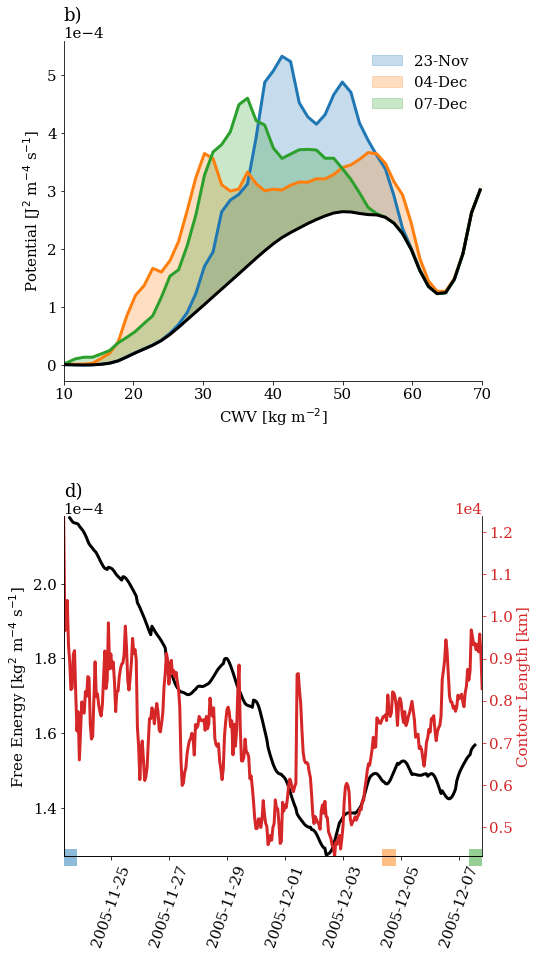

In [268]:
option = 'Agg' # Aggregating, potential averaged from imin_left to imax
option = 'Dis' # Disaggregating, potential averaged from imax to imin_right

plt.close('all')
fig,ax = plt.subplots(2,1,figsize=(7.5,15))
plt.subplots_adjust(hspace=0.33)


ax[0].set_title('b)',pad=20, loc = 'left')
ax[0].set_xlabel(r'CWV [kg m$^{-2}$]')
ax[0].set_ylabel(r'Potential [J$^{2}$ m$^{-4}$ s$^{-1}$]')

ax[0].set_xlim(10,70)

for i, time_lab in enumerate(times_labels):
    ax[0].fill_between(binm_Vfinal, Vfinal, Vfinal+dic_hist[time_lab]*5e-3,color=col_A[i],label=time_lab, alpha = 0.25)
    ax[0].plot(binm_Vfinal, Vfinal+dic_hist[time_lab]*5e-3,color=col_A[i])
    
ax[0].plot(binm_Vfinal, Vfinal,color='k')

ax[0].legend(frameon=False)

time_period = time_A[np.where((time_A>times_A[0]-np.timedelta64(6,'h'))&(time_A<times_A[-1]+np.timedelta64(6,'h')))]
cont_period = cont_t[np.where((time_A>times_A[0]-np.timedelta64(6,'h'))&(time_A<times_A[-1]+np.timedelta64(6,'h')))]

axbis = ax[1].twinx()
axbis.plot(time_period, cont_period,color='C3')
#axbis.plot(time_period, gaussian_filter1d(cont_period, sigma=12), 'C3:')
axbis.spines['right'].set_color('C3')
axbis.tick_params(axis='y', colors='C3')

axbis.set_ylabel('Contour Length [km]',color='C3')

ax[0].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)

ax[0].spines['right'].set_visible(False)
axbis.spines['right'].set_visible(False)

ax[1].plot(PWAtl_F.time, Ffinal,color='k')
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=70 )


ymin_C, ymax_C = 4.301e3, 1.2377e4
axbis.set_ylim(ymin_C, ymax_C)

# From https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/fill_between_demo.html
trans = mtransforms.blended_transform_factory(ax[1].transData, ax[1].transAxes)
period_y_max, period_y_min = -0.03, 0.02

for i, time in enumerate(times_A):

    print(time-np.timedelta64(12,'h'), time+np.timedelta64(12,'h'))
    ax[1].fill_between(x=time_period,y1=period_y_min,y2=period_y_max,
                       where=(time_period<=(time+np.timedelta64(6,'h')))&(time_period>=(time-np.timedelta64(6,'h'))),
                       facecolor=col_A[i],alpha=0.5,transform=trans, clip_on = False)
    
    print(len(np.where(((time_period>=(time-np.timedelta64(6,'h')))&(time_period<=(time+np.timedelta64(6,'h')))))[0]))

ax[1].set_xlim((time_period.min(),time_period.max()))
#ymin_F, ymax_F = 3.5e-4, 5.2e-4 #ax[1].get_ylim() # For aggregation on Dec2
ymin_F, ymax_F = 1.27e-4, 2.18e-4 #ax[1].get_ylim() # For aggregation on Dec4
ax[1].set_ylim((ymin_F, ymax_F))
ax[1].set_title('d)',loc='left', pad = 20)
ax[1].set_ylabel(r'Free Energy [kg$^{2}$ m$^{-4}$ s$^{-1}$]')

ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
axbis.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')

plt.subplots_adjust(hspace = 0.4)

ax[1].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)

In [137]:
Ffinal.min()

0.0003686879078201546

In [138]:
Ffinal.max()

0.0005153938672284994

In [139]:
cont_period.max()

12376.954364826302

In [140]:
cont_period.min()

4301.39087296526

### Save reduced data

In [286]:
hf = open(pathPKL+'2020_01_08_ERA5_LFE.pkl','wb')

In [287]:
F2b_data = {'binm_Vfinal':binm_Vfinal,'Vfinal':Vfinal,
           'times_labels':times_labels,'dic_hist':dic_hist,
           'col_A':col_A,'time_A':time_A,'times_A':times_A,
           'time_period':time_period,'cont_period':cont_period,
           'LFE_time':PWAtl_F.time,'Ffinal':Ffinal,'cont_t':cont_t,
           }

In [288]:
pickle.dump(F2b_data,hf)
hf.close()

### Make Figure from reduced data

In [109]:
path = pathPKL+'2020_01_08_ERA5_LFE.pkl'
hf = open(path,'rb')
S = pickle.load(hf)
F2b = Bunch(S)

2005-11-23T02:00:00.000000000 2005-11-24T02:00:00.000000000
2005-12-04T02:00:00.000000000 2005-12-05T02:00:00.000000000
2005-12-07T02:00:00.000000000 2005-12-08T02:00:00.000000000


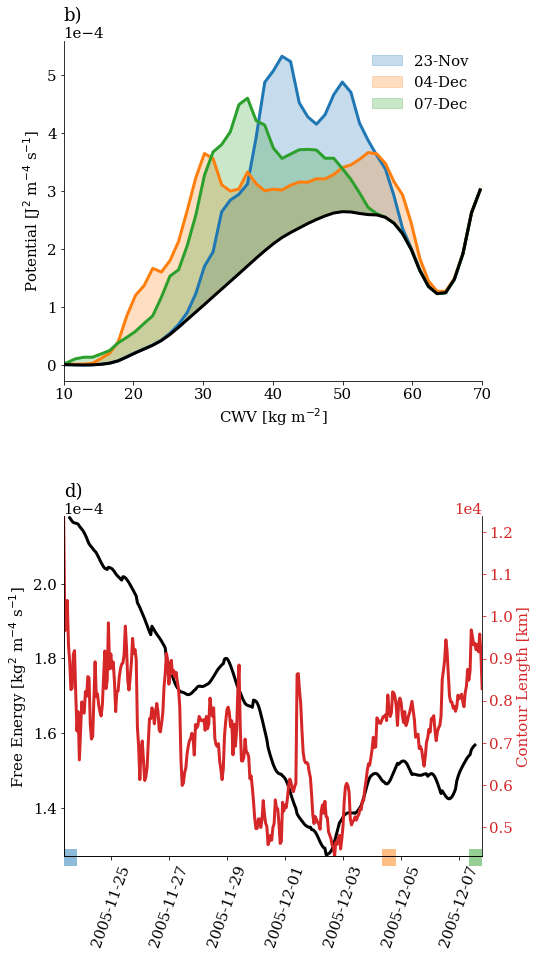

In [272]:
option = 'Agg' # Aggregating, potential averaged from imin_left to imax
option = 'Dis' # Disaggregating, potential averaged from imax to imin_right

plt.close('all')
fig,ax = plt.subplots(2,1,figsize=(7.5,15))
plt.subplots_adjust(hspace=0.33)


ax[0].set_title('b)',pad=20, loc = 'left')
ax[0].set_xlabel(r'CWV [kg m$^{-2}$]')
ax[0].set_ylabel(r'Potential [J$^{2}$ m$^{-4}$ s$^{-1}$]')

ax[0].set_xlim(10,70)

for i, time_lab in enumerate(F2b.times_labels):
    ax[0].fill_between(F2b.binm_Vfinal, F2b.Vfinal, F2b.Vfinal+F2b.dic_hist[time_lab]*5e-3,
                       color=F2b.col_A[i],label=time_lab, alpha = 0.25)
    ax[0].plot(F2b.binm_Vfinal, F2b.Vfinal+F2b.dic_hist[time_lab]*5e-3,
               color=F2b.col_A[i])
    
ax[0].plot(F2b.binm_Vfinal, F2b.Vfinal,color='k')

ax[0].legend(frameon=False)

time_period = time_A[np.where((F2b.time_A>F2b.times_A[0]-np.timedelta64(6,'h'))&\
                              (F2b.time_A<F2b.times_A[-1]+np.timedelta64(6,'h')))]
cont_period = cont_t[np.where((F2b.time_A>F2b.times_A[0]-np.timedelta64(6,'h'))&\
                              (F2b.time_A<F2b.times_A[-1]+np.timedelta64(6,'h')))]

axbis = ax[1].twinx()
axbis.plot(F2b.time_period, F2b.cont_period,color='C3')
#axbis.plot(time_period, gaussian_filter1d(cont_period, sigma=12), 'C3:')
axbis.spines['right'].set_color('C3')
axbis.tick_params(axis='y', colors='C3')

axbis.set_ylabel('Contour Length [km]',color='C3')

ax[0].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)

ax[0].spines['right'].set_visible(False)
axbis.spines['right'].set_visible(False)

ax[1].plot(F2b.LFE_time, F2b.Ffinal,color='k')
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=70 )


ymin_C, ymax_C = 4.301e3, 1.2377e4
axbis.set_ylim(ymin_C, ymax_C)

# From https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/fill_between_demo.html
trans = mtransforms.blended_transform_factory(ax[1].transData, ax[1].transAxes)
period_y_max, period_y_min = -0.03, 0.02

for i, time in enumerate(F2b.times_A):

    print(time-np.timedelta64(12,'h'), time+np.timedelta64(12,'h'))
    ax[1].fill_between(x=F2b.time_period,y1=period_y_min,y2=period_y_max,
                       where=(F2b.time_period<=(time+np.timedelta64(6,'h')))&\
                       (F2b.time_period>=(time-np.timedelta64(6,'h'))),
                       facecolor=F2b.col_A[i],alpha=0.5,transform=trans, clip_on = False)
    
    #print(len(np.where(((time_period>=(time-np.timedelta64(6,'h')))&(time_period<=(time+np.timedelta64(6,'h')))))[0]))

ax[1].set_xlim((F2b.time_period.min(),F2b.time_period.max()))
#ymin_F, ymax_F = 3.5e-4, 5.2e-4 #ax[1].get_ylim() # For aggregation on Dec2
ymin_F, ymax_F = 1.27e-4, 2.18e-4 #ax[1].get_ylim() # For aggregation on Dec4
ax[1].set_ylim((ymin_F, ymax_F))
ax[1].set_title('d)',loc='left', pad = 20)
ax[1].set_ylabel(r'Free Energy [kg$^{2}$ m$^{-4}$ s$^{-1}$]')

ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
axbis.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')

plt.subplots_adjust(hspace = 0.4)

ax[1].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)

### Calculate timescales of potential and contour

In [116]:
CL_autocor = np.correlate(F2b.cont_period,F2b.cont_period,mode='full')
CL_AC = CL_autocor[int(CL_autocor.size/2):]

In [118]:
tcoor = 3600*np.arange(0,np.size(CL_AC))

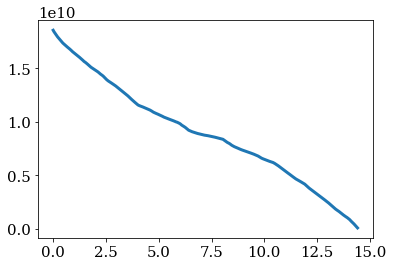

In [119]:
plt.plot(tcoor/(24*3600),CL_AC)

In [120]:
efold = (tcoor[:CL_AC.size]/(24*3600))[np.argmin(np.abs(CL_AC-np.max(CL_AC)/np.exp(1)))]

In [121]:
efold

9.708333333333334

In [124]:
F2b.binm_Vfinal.shape

(50,)

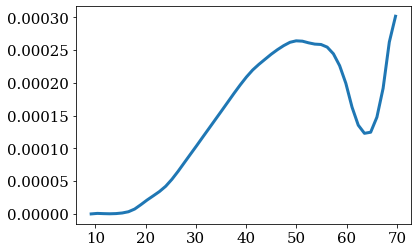

In [147]:
plt.plot(F2b.binm_Vfinal,F2b.Vfinal)

In [161]:
imin = np.argmin(F2b.Vfinal[:30])
imid = np.argmax(F2b.Vfinal[10:40])+10
imax = np.argmin(F2b.Vfinal[30:])+30
ind = [imin,imid,imax]
print(ind)
xind = F2b.binm_Vfinal[ind]
print(xind)
yind = F2b.Vfinal[ind]
print(yind)

[0, 33, 44]
[ 9.185986 49.949203 63.53694 ]
[0.         0.00026407 0.00012296]


In [162]:
dr = xind[-1]-xind[1]
dl = xind[0]-xind[1]
print(dl,dr)
print(dr-dl)
print(dl*dr**2-dr*dl**2)

-40.763218 13.587738
54.350956
-30103.903506481423


In [163]:
V2_estimate = 2*(dl*yind[2]-dr*yind[0]+(dr-dl)*yind[1])/(dl*dr**2-dr*dl**2)

In [164]:
tau_V2 = -1/(24*3600*V2_estimate)
print(tau_V2)

18.65174881465595


In [166]:
C = np.polyfit(x=F2b.binm_Vfinal[imin:imax],y=F2b.Vfinal[imin:imax],deg=2)

In [169]:
C2 = np.polyfit(x=xind,y=yind,deg=2)

(-0.0002, 0.0004)

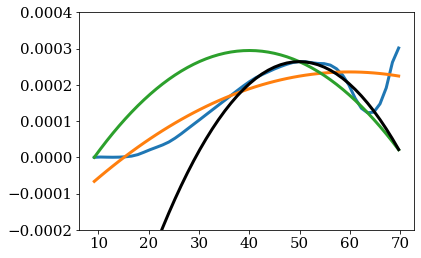

In [176]:
plt.plot(F2b.binm_Vfinal,F2b.Vfinal)
plt.plot(F2b.binm_Vfinal,C[0]*F2b.binm_Vfinal**2+C[1]*F2b.binm_Vfinal**1+C[2]*F2b.binm_Vfinal**0)
plt.plot(F2b.binm_Vfinal,C2[0]*F2b.binm_Vfinal**2+C2[1]*F2b.binm_Vfinal**1+C2[2]*F2b.binm_Vfinal**0)
plt.plot(F2b.binm_Vfinal,V2_estimate*(F2b.binm_Vfinal-F2b.binm_Vfinal[imid])**2+F2b.Vfinal[imid],color='k')
plt.ylim((-2e-4,4e-4))

In [172]:
print(tau_V2,-1/(24*3600*C[0]),-1/(24*3600*C2[0]))

18.65174881465595 98.56969361419776 37.303497629311885


## 2.3) Combine all subplots into single Figure

2005-11-23T02:00:00.000000000 2005-11-24T02:00:00.000000000
2005-12-04T02:00:00.000000000 2005-12-05T02:00:00.000000000
2005-12-07T02:00:00.000000000 2005-12-08T02:00:00.000000000


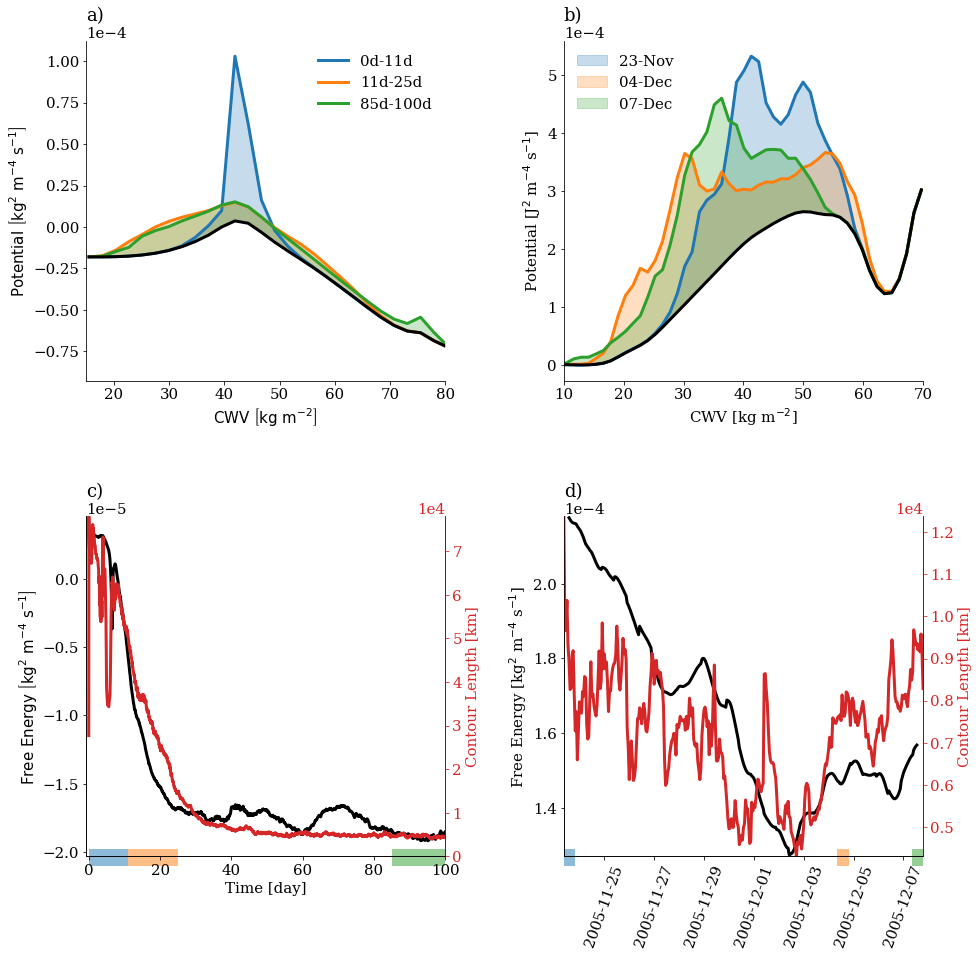

In [285]:
### Figure 2a,c
fig,ax0 = plt.subplots(2,2,figsize=(15,15))
plt.subplots_adjust(hspace=0.33,wspace=0.33)

### Figure 2a
ax = {}
ax[0] = ax0[0][0]
ax[0].set_xlim((15,80))
# ax[0].set_ylim((-1.5e8,1e9))
ax[0].set_title('a)',loc = 'left', pad=20)
ax[0].set_xlabel(r'$\mathrm{CWV}\ \left[\mathrm{kg\ m^{-2}}\right]$')
ax[0].set_ylabel(r'$\mathrm{Potential\ \left[kg^{2}\ m^{-4}\ s^{-1}\right]}$')

ax[0].fill_between((edgTObin(F2a.SPINedges)),F2a.V,F2a.V+F2a.CWV_PDF_SPIN*5e-4,color=F2a.col_A[0], alpha = 0.25)
ax[0].fill_between((edgTObin(F2a.COALedges)),F2a.V,F2a.V+F2a.CWV_PDF_COAL*5e-4,color=F2a.col_A[1], alpha = 0.25)
ax[0].fill_between((edgTObin(F2a.COARedges)),F2a.V,F2a.V+F2a.CWV_PDF_COAR*5e-4,color=F2a.col_A[2], alpha = 0.25)


ax[0].plot((edgTObin(F2a.SPINedges)),F2a.V+F2a.CWV_PDF_SPIN*5e-4,color=F2a.col_A[0],label='0d-11d')
ax[0].plot((edgTObin(F2a.COALedges)),F2a.V+F2a.CWV_PDF_COAL*5e-4,color=F2a.col_A[1],label='11d-25d')
ax[0].plot((edgTObin(F2a.COARedges)),F2a.V+F2a.CWV_PDF_COAR*5e-4,color=F2a.col_A[2],label='85d-100d')
ax[0].legend(frameon=False,loc='upper right')

ax[0].plot(F2a.binm,F2a.V,color='k')

### Figure 2c
ax[1] = ax0[1][0]
axbis = ax[1].twinx()
axbis.plot(F2a.tcoor/(24*3600),F2a.CL/1e3,color='C3')

ymin_C, ymax_C = 0, np.max(F2a.CL)/1e3

axbis.spines['right'].set_color('C3')
axbis.tick_params(axis='y', colors='C3')
axbis.set_ylim((ymin_C, ymax_C))
axbis.set_ylabel('Contour Length [km]',color='C3')

ax[0].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)

ax[0].spines['right'].set_visible(False)
axbis.spines['right'].set_visible(False)

ax[1].plot(F2a.tcoor/(24*3600),F2a.Ffinal_RCE,color='k')
ymin_F, ymax_F = ax[1].get_ylim()

# From https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/fill_between_demo.html
trans = mtransforms.blended_transform_factory(ax[1].transData, ax[1].transAxes)
period_y_max, period_y_min = -0.03, 0.02

ax[1].fill_between(x=F2a.tcoor/(24*3600),y1=period_y_min,y2=period_y_max,
                   where=(tcoor/(24*3600)<=11)&(tcoor/(24*3600)>=0),
                   facecolor=col_A[0],alpha=0.5,transform=trans, clip_on=False)
ax[1].fill_between(x=F2a.tcoor/(24*3600),y1=period_y_min,y2=period_y_max,
                   where=(tcoor/(24*3600)<=25)&(tcoor/(24*3600)>=11),
                   facecolor=col_A[1],alpha=0.5,transform=trans, clip_on=False)
ax[1].fill_between(x=F2a.tcoor/(24*3600),y1=period_y_min,y2=period_y_max,
                   where=(tcoor/(24*3600)<=100)&(tcoor/(24*3600)>=85),
                   facecolor=col_A[2],alpha=0.5,transform=trans, clip_on=False)

ax[1].set_title('c)',loc='left', pad=20)
ax[1].set_xlim((-0.75,100))
ax[1].set_ylim((ymin_F, ymax_F))
ax[1].set_xlabel('Time [day]')
ax[1].set_ylabel(r'$\mathrm{Free\ Energy\ \left[kg^{2}\ m^{-4}\ s^{-1}\right]}$')

ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
axbis.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')

ax[1].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)

### Figure 2b,d
option = 'Agg' # Aggregating, potential averaged from imin_left to imax
option = 'Dis' # Disaggregating, potential averaged from imax to imin_right

### Figure 2b
ax = {}
ax[0] = ax0[0][1]

ax[0].set_title('b)',pad=20, loc = 'left')
ax[0].set_xlabel(r'CWV [kg m$^{-2}$]')
ax[0].set_ylabel(r'Potential [J$^{2}$ m$^{-4}$ s$^{-1}$]')

ax[0].set_xlim(10,70)

for i, time_lab in enumerate(F2b.times_labels):
    ax[0].fill_between(F2b.binm_Vfinal, F2b.Vfinal, F2b.Vfinal+F2b.dic_hist[time_lab]*5e-3,
                       color=F2b.col_A[i],label=time_lab, alpha = 0.25)
    ax[0].plot(F2b.binm_Vfinal, F2b.Vfinal+F2b.dic_hist[time_lab]*5e-3,
               color=F2b.col_A[i])
    
ax[0].plot(F2b.binm_Vfinal, F2b.Vfinal,color='k')

ax[0].legend(frameon=False)

time_period = time_A[np.where((F2b.time_A>F2b.times_A[0]-np.timedelta64(6,'h'))&\
                              (F2b.time_A<F2b.times_A[-1]+np.timedelta64(6,'h')))]
cont_period = cont_t[np.where((F2b.time_A>F2b.times_A[0]-np.timedelta64(6,'h'))&\
                              (F2b.time_A<F2b.times_A[-1]+np.timedelta64(6,'h')))]

### Figure 2d
ax[1] = ax0[1][1]
axbis = ax[1].twinx()
axbis.plot(F2b.time_period, F2b.cont_period,color='C3')
#axbis.plot(time_period, gaussian_filter1d(cont_period, sigma=12), 'C3:')
axbis.spines['right'].set_color('C3')
axbis.tick_params(axis='y', colors='C3')

axbis.set_ylabel('Contour Length [km]',color='C3')

ax[0].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)

ax[0].spines['right'].set_visible(False)
axbis.spines['right'].set_visible(False)

ax[1].plot(F2b.LFE_time, F2b.Ffinal,color='k')
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=70 )


ymin_C, ymax_C = 4.301e3, 1.2377e4
axbis.set_ylim(ymin_C, ymax_C)

# From https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/fill_between_demo.html
trans = mtransforms.blended_transform_factory(ax[1].transData, ax[1].transAxes)
period_y_max, period_y_min = -0.03, 0.02

for i, time in enumerate(F2b.times_A):

    print(time-np.timedelta64(12,'h'), time+np.timedelta64(12,'h'))
    ax[1].fill_between(x=F2b.time_period,y1=period_y_min,y2=period_y_max,
                       where=(F2b.time_period<=(time+np.timedelta64(6,'h')))&\
                       (F2b.time_period>=(time-np.timedelta64(6,'h'))),
                       facecolor=F2b.col_A[i],alpha=0.5,transform=trans, clip_on = False)
    
    #print(len(np.where(((time_period>=(time-np.timedelta64(6,'h')))&(time_period<=(time+np.timedelta64(6,'h')))))[0]))

ax[1].set_xlim((F2b.time_period.min(),F2b.time_period.max()))
#ymin_F, ymax_F = 3.5e-4, 5.2e-4 #ax[1].get_ylim() # For aggregation on Dec2
ymin_F, ymax_F = 1.27e-4, 2.18e-4 #ax[1].get_ylim() # For aggregation on Dec4
ax[1].set_ylim((ymin_F, ymax_F))
ax[1].set_title('d)',loc='left', pad = 20)
ax[1].set_ylabel(r'Free Energy [kg$^{2}$ m$^{-4}$ s$^{-1}$]')

ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
axbis.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')

plt.subplots_adjust(hspace = 0.4)

ax[1].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)

# 3) Appendix Figure (MSE)

Ideally, repeat case study in ERA5. For now, using the old case study.